In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

import xgboost as xgb

In [2]:
df = pd.read_csv('../input/xytest/aaa.csv')
eda_df = pd.read_csv('../input/xytest/aaa.csv')

In [3]:
ratio_test = 0.2
ratio_val = 0.25
ratio_features_corr = 0.1
ratio_noise = 0.06
nums_data_aug = 25

In [4]:
print(df.isna().sum())
df = df.fillna(df.mean())

participant     0
0               0
1               0
2               0
3               0
4               0
5               0
6               0
7               0
8               3
9              18
10             27
Label           0
dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [5]:
print(df.corr()['Label'])
features = list(df.corr()[df.corr()['Label']>ratio_features_corr].index)[:-1]
for i in range(nums_data_aug):
    eda_df[features] = eda_df[features]+np.random.random()*ratio_noise
    df = shuffle(pd.concat([df, eda_df]))

0        0.153713
1        0.172451
2        0.120248
3        0.113188
4        0.100174
5        0.121006
6        0.116507
7        0.059225
8        0.050610
9        0.111622
10       0.029064
Label    1.000000
Name: Label, dtype: float64


In [6]:
X, y = df[features], df['Label']-1

In [7]:
# xgboost param
param = {'max_depth': 3,
         'objective': 'binary:logistic',
         "eval_metric":"auc",
         "scale_pos_weight":8,
         "subsample":0.8,
         "min_child_weight":1,
          }

num_boost_round = 2000
early_stopping_rounds = 30
nfold = 10

epochs = 5
nums_exp = 2

In [8]:
def plot_roc(title, fprs, tprs):
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr,tpr, 'b', label='AUC = %0.01f' % auc(fpr,tpr))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [0, 1], 'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
    plt.title(title)
    plt.savefig('{}.pdf'.format(title), bbox_inches='tight')
    plt.show()

In [9]:
def plot_bar(title, y_test, y_pred, roc_auc):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen = tp / (tp+fn)
    spec = tn / (tn+fp)
    acc = (tp+tn) / (tn + fp + fn + tp)

    x=[1,2,3,4]
    y = [sen, spec, acc, roc_auc]
    label_list = ['Sens','Spec','Accu','AUC']
    plt.xticks(x, label_list) 
    plt.bar(x, y)
    plt.title(title)
    plt.savefig('{}.pdf'.format(title), bbox_inches='tight')
    plt.show()
    return y

Epochs  0 : Train accuracy =  0.9820912767186597  Validation accuracy =  0.8630849220103987


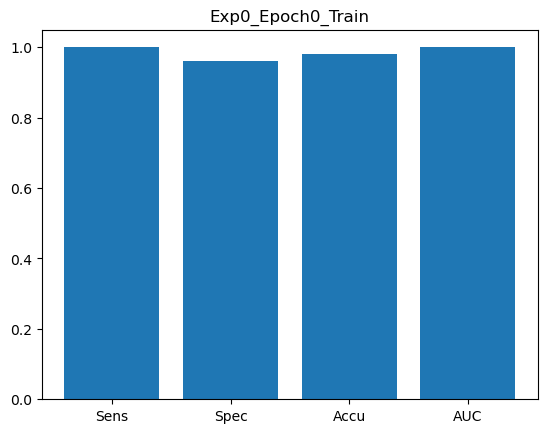

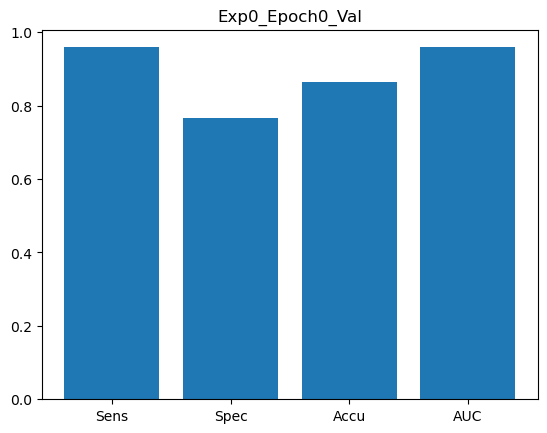

Epochs  1 : Train accuracy =  0.9977194982896237  Validation accuracy =  0.8790613718411552


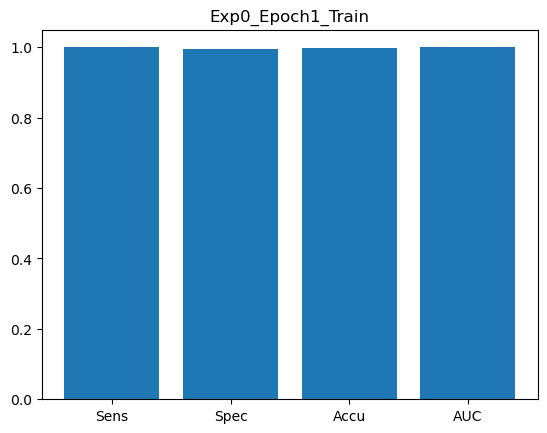

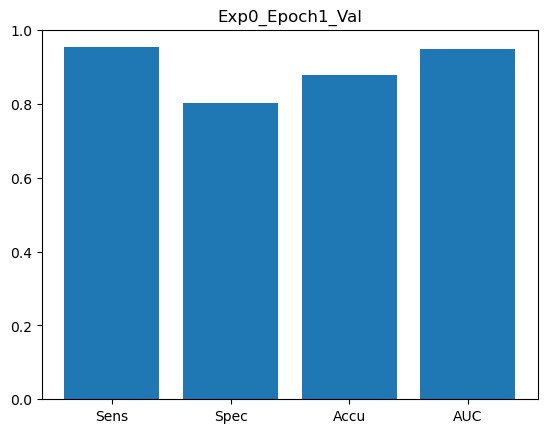

Epochs  2 : Train accuracy =  0.9938097917839055  Validation accuracy =  0.8813559322033898


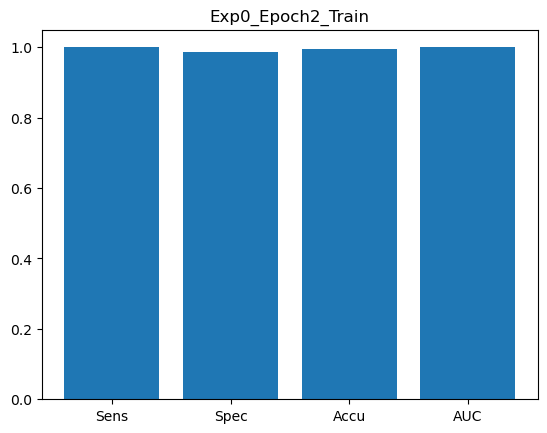

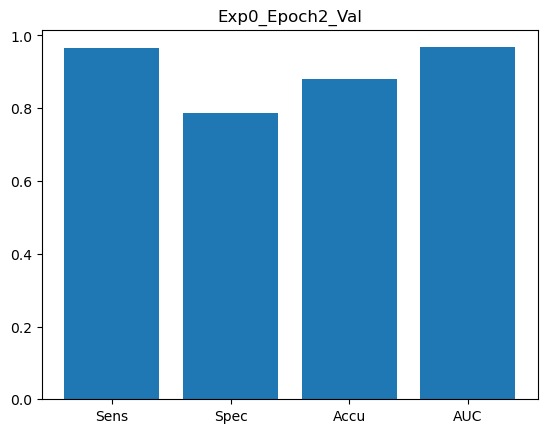

Epochs  3 : Train accuracy =  0.9961111111111111  Validation accuracy =  0.9094488188976378


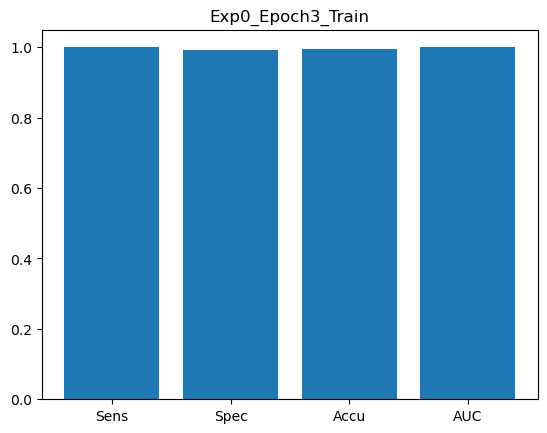

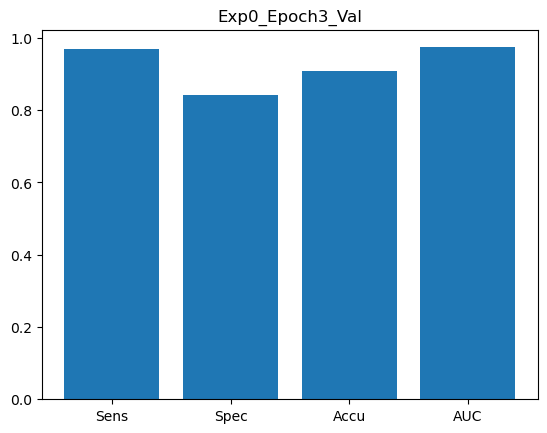

Epochs  4 : Train accuracy =  0.9983543609434997  Validation accuracy =  0.9072164948453608


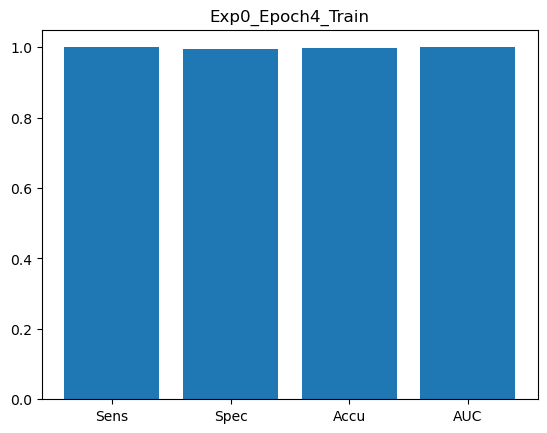

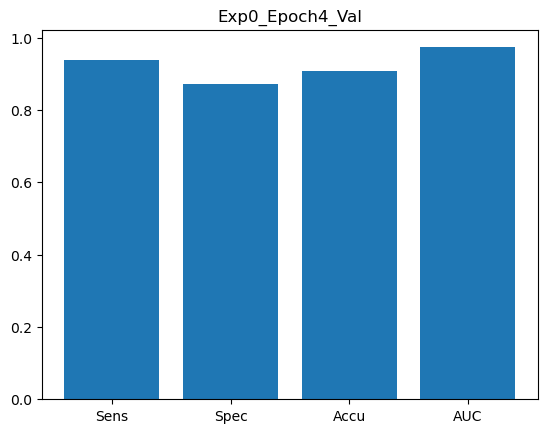

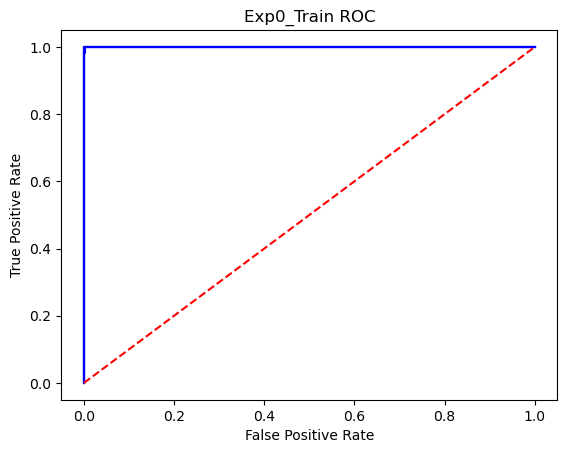

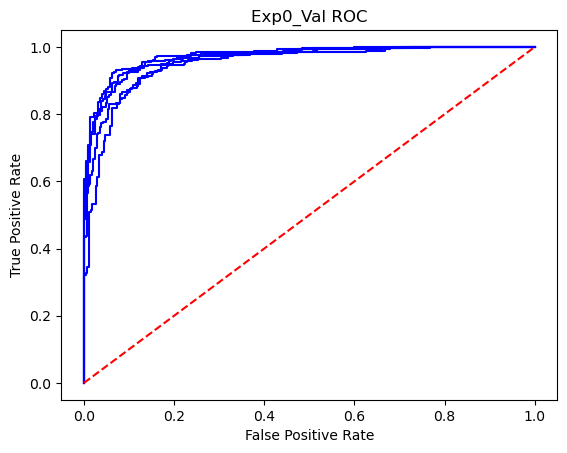

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       262
           1       0.90      0.96      0.92       316

    accuracy                           0.92       578
   macro avg       0.92      0.91      0.91       578
weighted avg       0.92      0.92      0.91       578
 
 0.9152249134948097


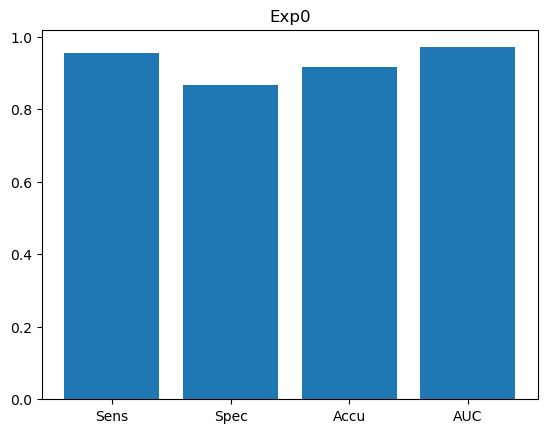

Epochs  0 : Train accuracy =  0.9965337954939342  Validation accuracy =  0.8908145580589255


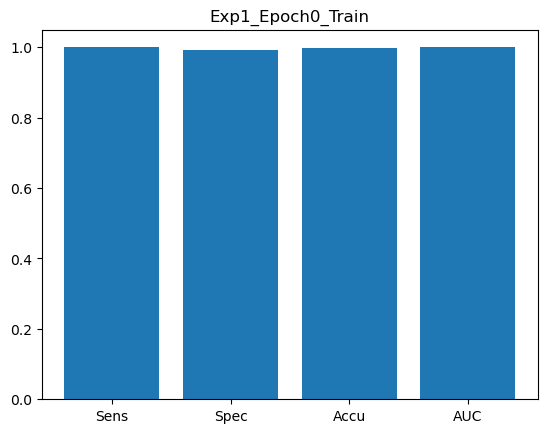

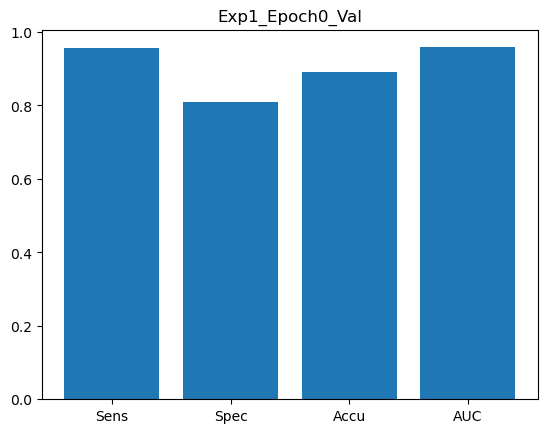

Epochs  1 : Train accuracy =  0.9948688711516533  Validation accuracy =  0.8880866425992779


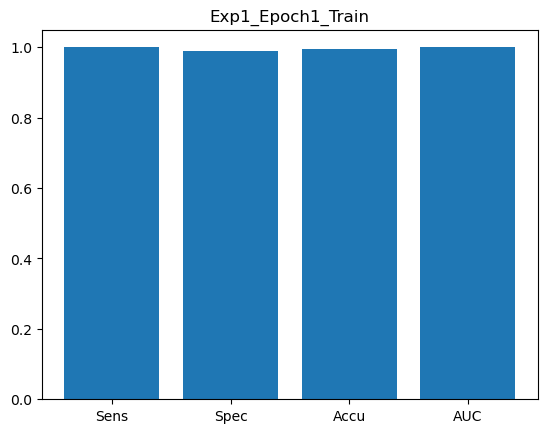

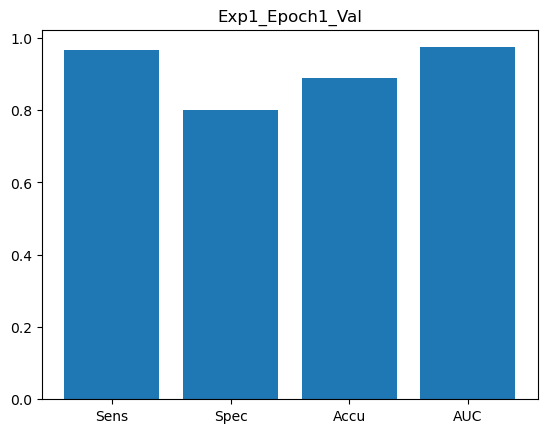

Epochs  2 : Train accuracy =  0.9994372537985369  Validation accuracy =  0.903954802259887


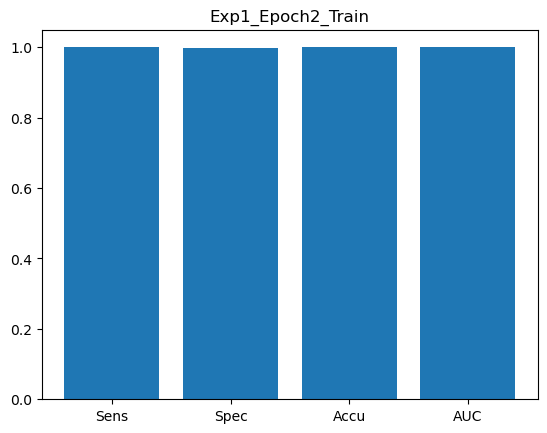

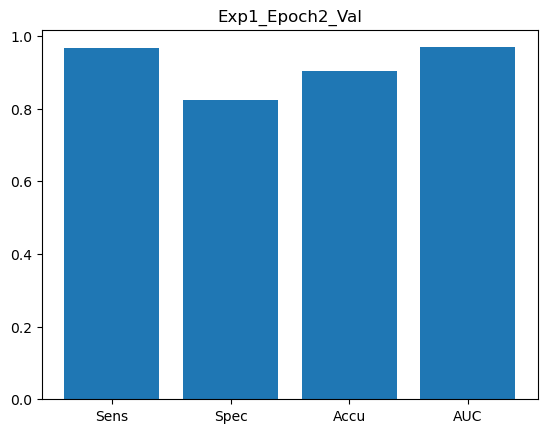

Epochs  3 : Train accuracy =  0.9888888888888889  Validation accuracy =  0.8858267716535433


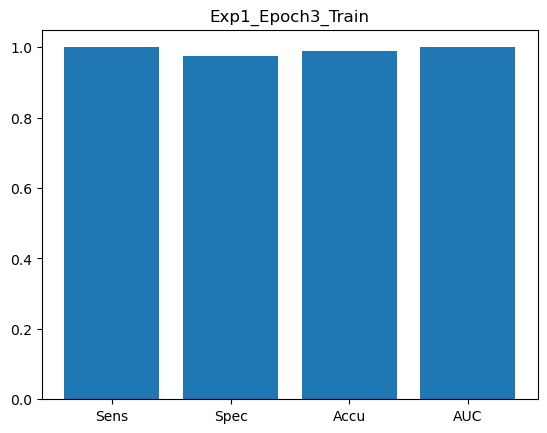

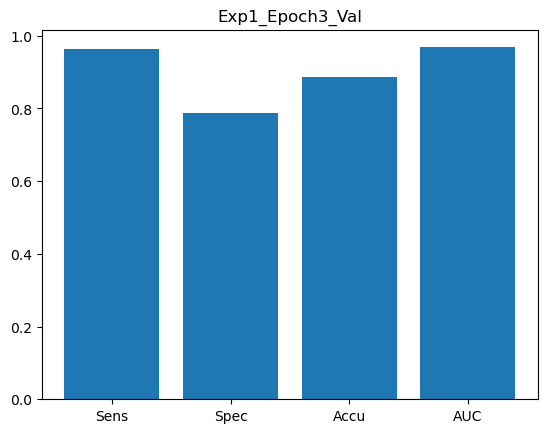

Epochs  4 : Train accuracy =  0.9972572682391662  Validation accuracy =  0.8639175257731959


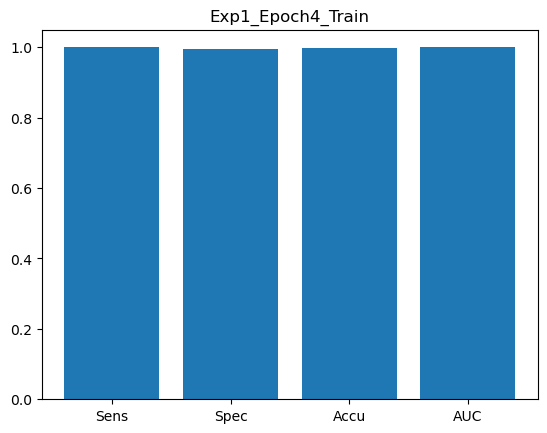

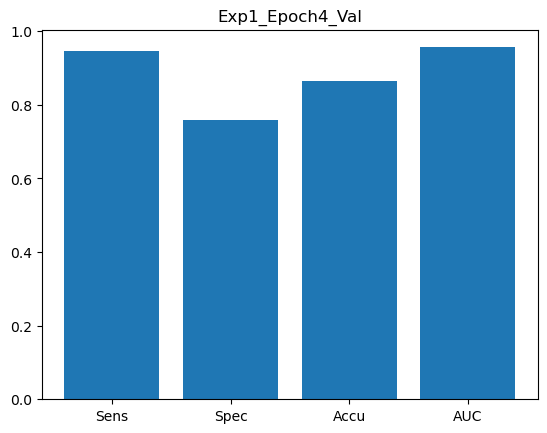

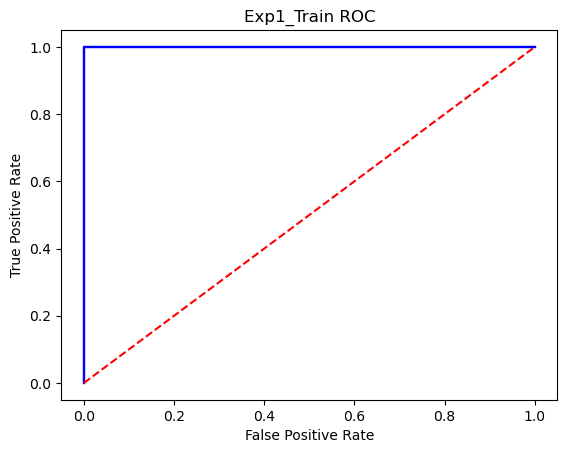

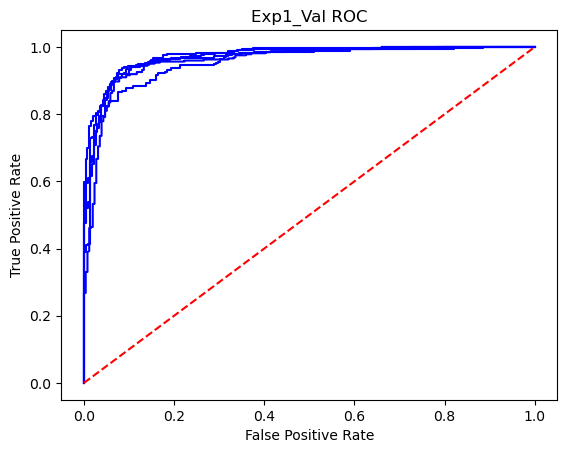

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       298
           1       0.82      0.98      0.90       280

    accuracy                           0.89       578
   macro avg       0.90      0.89      0.89       578
weighted avg       0.90      0.89      0.89       578
 
 0.889273356401384


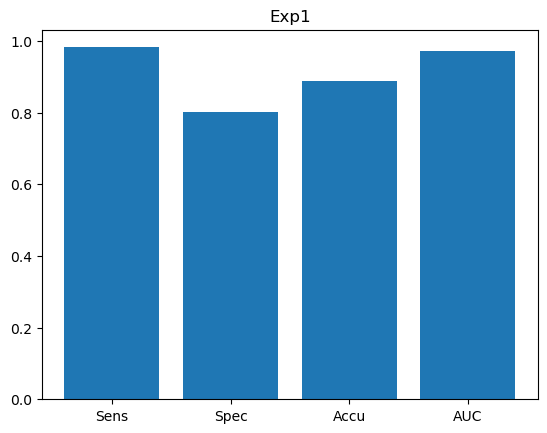

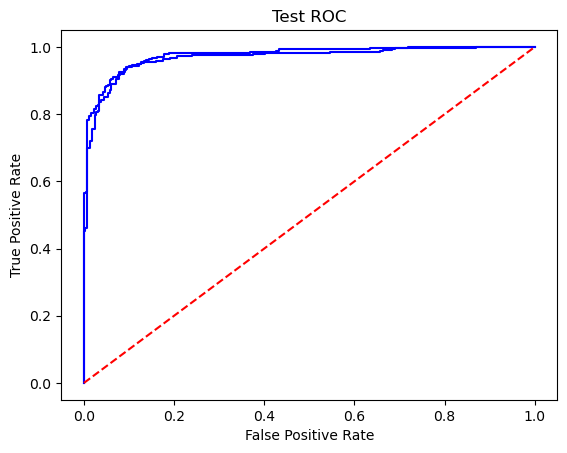

CPU times: user 13min 20s, sys: 11.9 s, total: 13min 32s
Wall time: 3min 29s


In [10]:
%%time


test_fprs = []
test_tprs = []

train_txt = []
val_txt = []
test_txt = []
for i in range(nums_exp):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio_test, shuffle=True)
    dtest  = xgb.DMatrix(X_test)
    
    y_train_preds = []
    y_val_preds = []
    
    fprs = []
    tprs = []
    val_fprs = []
    val_tprs = []
    
    for _ in range(epochs):
        X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=ratio_val-_*0.01, shuffle=True)
        
        dtrain = xgb.DMatrix(X_trn,label=y_trn)
        dtrn = xgb.DMatrix(X_trn)
        dval  = xgb.DMatrix(X_val)

        
        cv_res= xgb.cv(param,dtrain,num_boost_round=2000,early_stopping_rounds=10,nfold=10, metrics='auc',show_stdv=True)
        bst = xgb.train(param,dtrain,num_boost_round=cv_res.shape[0])
        y_train_pred_prob, y_val_pred_prob = bst.predict(dtrn), bst.predict(dval)
        
        y_train_pred = [int(i+0.5) for i in y_train_pred_prob]
        y_val_pred = [int(i+0.5) for i in y_val_pred_prob]
        
        print('Epochs ', _, ': Train accuracy = ', accuracy_score(y_train_pred,y_trn), ' Validation accuracy = ', accuracy_score(y_val_pred,y_val))
        
        
        fpr,tpr,threshold = roc_curve(y_trn, y_train_pred_prob)
        train_txt.append(plot_bar('Exp{0}_Epoch{1}_Train'.format(i, _), y_trn, y_train_pred, auc(fpr,tpr)))
        fprs.append(fpr)
        tprs.append(tpr)
        
        fpr,tpr,threshold = roc_curve(y_val, y_val_pred_prob)
        val_txt.append(plot_bar('Exp{0}_Epoch{1}_Val'.format(i, _), y_val, y_val_pred, auc(fpr,tpr)))
        val_fprs.append(fpr)
        val_tprs.append(tpr)

    
    plot_roc('Exp{0}_Train ROC'.format(i), fprs, tprs)
    plot_roc('Exp{0}_Val ROC'.format(i), val_fprs, val_tprs)
    
    
    y_pred_prob = bst.predict(dtest)
    y_pred = [int(i+0.5) for i in y_pred_prob]
    print(classification_report(y_test, y_pred), '\n', accuracy_score(y_pred,y_test))
    fpr,tpr,threshold = roc_curve(y_test, y_pred_prob)
    test_fprs.append(fpr)
    test_tprs.append(tpr)
    
    
    test_txt.append(plot_bar('Exp{0}'.format(i), y_test, y_pred, auc(fpr,tpr)))

plot_roc('Test ROC', test_fprs, test_tprs)

In [11]:
f_train = open("train.txt","w")

for s in train_txt:
    f_train.write(str(s)+'\n')
f_train.close()

f_train = open("val.txt","w")

for s in val_txt:
    f_train.write(str(s)+'\n')
f_train.close()

f_train = open("test.txt","w")

for s in test_txt:
    f_train.write(str(s)+'\n')
f_train.close()